# Exploratory work for the [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) challenge

## Example of using transfer learning for supervised classification

Here we try to apply transfer learning, using [`Keras`](https://keras.io).  
Specifically, we will reuse some models (`MobileNet`, `VGG`, `InceptionV3`) from the Keras [model zoo](https://keras.io/applications/), and perform standard data augmentation using  the [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) (see e.g. [here](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) for use examples).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import re
import time
import pickle
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, \
                         Flatten, Dense, GlobalMaxPooling2D, \
                         AveragePooling2D, GlobalAveragePooling2D, \
                         MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16

from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

from IAFlash.helpers_core import scaleConvNet1_image

/Users/arthur/anaconda3/envs/tree/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge299bwFalseresampleFilter0') # InceptionV3 / VGG
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwFalseresampleFilter0') # (small) MobileNet
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0') # dummy model
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
data_format = 'channels_last'
nbClass = 196

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    
batchSize_trainGen = 32

# model design params
nScale_scaleConvNet = 4
filter_scaleConvNet = 10

# model compilation params
loss = 'categorical_crossentropy'
optim = 'adam'
metric = ['accuracy']

# model training params
epochs = 10
earlystop = EarlyStopping(monitor='val_acc',
                          min_delta=0,
                          patience=20,
                          verbose=1)
checkpoint = ModelCheckpoint(os.path.join(pathToIntellDir, 'model_v0.hdf5'),
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             period=1)
reducelr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.1,
                             patience=4,
                             verbose=1)

# seed
seed = 8
np.random.seed(seed)

### Intelligence

**Data augmentation**

Data augmentation consists in running on the training images some usual transformations that do not change the class while adding more variability to the dataset. Examples for cars are horizontal flipening, small rotations.  
The [`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/preprocessing/image/) object allows to augment data easily. Depending on the method used, data augmentation can be done once-for-all or on-the-fly. We will choose on-the-fly augmentation to avoid storing too large data.

In [3]:
# prepare a dataset augmenter

# NB: only train data need augmentation
train_datagen = ImageDataGenerator(featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False, # explore this later
                                   zca_epsilon=1e-06,
                                   rotation_range=20, # 0
                                   width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   shear_range=0.0,
                                   zoom_range=0.0,
                                   channel_shift_range=0.0,
                                   fill_mode='constant', #'nearest',
                                   cval=0.0,
                                   horizontal_flip=True, # False
                                   vertical_flip=False,
                                   rescale=1./255, # None
                                   preprocessing_function=None,
                                   data_format=data_format)

train_generator = train_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Train'), # "it should contain one subdirectory per class"
                                                    target_size=(edge, edge),
                                                    color_mode=mode,
                                                    classes=None, # will infer from the directory structure
                                                    class_mode='categorical',
                                                    batch_size=batchSize_trainGen,
                                                    shuffle=True,
                                                    seed=seed,
                                                    follow_links=False,
                                                    interpolation='nearest',
#                                                     save_to_dir=pathToDataDir, # use this to print one batch when calling train_generator[batchIdx]
#                                                     save_prefix='train_',      #
#                                                     save_format='png'          #
                                                   )

# NB: validation data use `ImageDataGenerator` only for the conveniance of directory parsing
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Validation'),
                                                              target_size=(edge, edge),
                                                              color_mode=mode,
                                                              class_mode='categorical',
                                                              batch_size=1, # most basic behaviour
                                                              seed=seed,
#                                                               save_to_dir=pathToDataDir, # use this to print one batch when calling validation_generator[batchIdx]
#                                                               save_prefix='valid_',      #
#                                                               save_format='png'          #
                                                             )

# NB: same thing for test data
test_datagen = validation_datagen

test_generator = test_datagen.flow_from_directory(os.path.join(pathToDataDir, 'Test'),
                                                  target_size=(edge, edge),
                                                  color_mode=mode,
                                                  class_mode='categorical',
                                                  batch_size=1, # most basic behaviour
                                                  seed=seed)

Found 8144 images belonging to 196 classes.
Found 1561 images belonging to 195 classes.
Found 6480 images belonging to 196 classes.


train data:


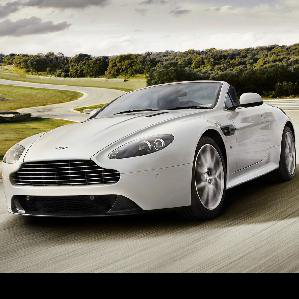

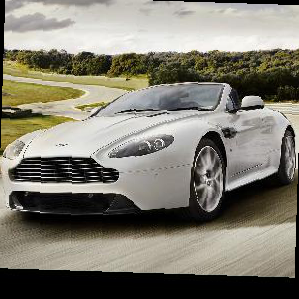

validation data (should not change):


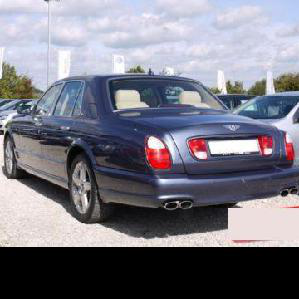

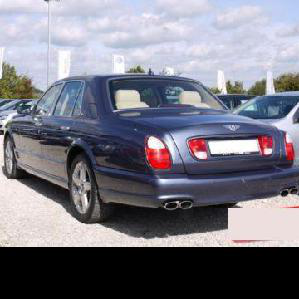

In [4]:
# example of data augmentation
i = 300

print('train data:')
im = Image.open(os.path.join(pathToDataDir, 'Train', train_generator.filenames[i]))
x_im = np.array(im)
if 2 == x_im.ndim: x_im = x_im.reshape((edge, edge, 1))
x_im_t = train_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0])
if 1 == x_im_t.shape[-1]: x_im_t = x_im_t.reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

print('validation data (should not change):')
im = Image.open(os.path.join(pathToDataDir, 'Validation', validation_generator.filenames[i]))
x_im = np.array(im)
if 2 == x_im.ndim: x_im = x_im.reshape((edge, edge, 1))
x_im_t = validation_datagen.random_transform(x_im, seed=np.random.choice(100,1)[0])
if 1 == x_im_t.shape[-1]: x_im_t = x_im_t.reshape(edge, edge)
im_t = Image.fromarray(x_im_t)

display(im)
display(im_t)

**Try different models**  

*Note*: in this section we show some exploratory attempts. Yet, (i) the cells may require some time to run; (ii) all cells do not work with the same data exactly; (iii) more work is needed to achieve interesting performances. As such, here we comment out the cells and rather print the outputs when relevant.

- Try a basic (kind of) CNN (only works for grayscale `(N,N,1)` images). Pure CNN approaches may have problems to succeed given the relatively low amount of data here.

In [5]:
# model = scaleConvNet1_image(edge, nbClass,
#                             nScale_scaleConvNet,
#                             int(196*filter_scaleConvNet/nScale_scaleConvNet))

# # compile

# model.compile(loss=loss,
#               optimizer=optim,
#               metrics=metric)

# # train

# model_history = model.fit_generator(train_generator,
#                                     epochs=epochs,
#                                     steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
#                                     validation_data=validation_generator,
#                                     validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
#                                     callbacks=[earlystop,checkpoint,reducelr])

In [6]:
#------ results
# ...
# Epoch 00010: val_acc did not improve
# 254/254 [==============================] - 300s 1s/step
# - loss: 4.6750 - acc: 0.0640 - val_loss: 5.1459 - val_acc: 0.0392

- Now try transfer learning. Transfer learning consists in starting from a model that has been already trained on a large amount of data (here they are trained on [ImageNet](http://www.image-net.org)), changing only the last (classifying) layers, and training the model on the data of interst.

  - - Try [MobileNet](https://keras.io/applications/#mobilenet) (only works for `(128,128,3)`, `(160,160,3)`, `(192,192,3)`, or `(224, 224,3)` data).

In [7]:
# for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

In [8]:
# # create model structure, from the base model

# # create the base pre-trained model
# base_model = MobileNet(input_shape=train_generator.image_shape,
#                        weights='imagenet',
#                        include_top=False,
#                        alpha=1.0,
#                        depth_multiplier=1,
#                        dropout=0.001)

# # add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # add a top-level classifier (may have multiple layers)
# x = Dense(2*train_generator.num_classes, activation='relu')(x)
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# # total model
# model = Model(inputs=base_model.input, outputs=predictions)
# model.summary()

In [9]:
# # train only the top layers

# iLayerTrain = len(model.layers)-2

# for i,layer in enumerate(model.layers):
#     if i < iLayerTrain:
#         layer.trainable = False

# model.summary()
        
# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(loss=loss,
#               optimizer=optim,
#               metrics=metric)

# # train
# model_history = model.fit_generator(train_generator,
#                                     epochs=epochs,
#                                     steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
#                                     validation_data=validation_generator,
#                                     validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
#                                     callbacks=[earlystop,checkpoint,reducelr])

In [10]:
#-- results
# ...
# Epoch 00010: val_acc did not improve
# 254/254 [==============================] - 157s 619ms/step
# - loss: 2.1789 - acc: 0.4485 - val_loss: 4.8961 - val_acc: 0.1213

(If needed:) we could try to train once again, but more of the top layers...

In [11]:
# iLayerTrain = len(model.layers)-10

# for i,layer in enumerate(model.layers):
#     if i < iLayerTrain:
#         layer.trainable = False

# model.summary()
        
# # compile the model (should be done *after* setting layers to non-trainable)
# model.compile(loss=loss,
#               optimizer=optim,
#               metrics=metric)

# # train
# model_history = model.fit_generator(train_generator,
#                                     epochs=epochs,
#                                     steps_per_epoch=int(train_generator.n/train_generator.batch_size), # as advised in docstring
#                                     validation_data=validation_generator,
#                                     validation_steps=int(validation_generator.n/validation_generator.batch_size), # as advised in docstring
#                                     callbacks=[earlystop,checkpoint,reducelr])

- - Try [`VGG`](https://keras.io/applications/#vgg16) (only works for `(299,299,3)` data) as a feature extractor for a subsequent linear classifier. We see that the features on top of `VGG-Imagenet` are actually not suited for our specific task of car detection. This is expected, and we may have to retrain some of the last convolutional layers.

In [12]:
# # create model structure, from a base model

# base_model = VGG16(weights='imagenet', include_top=False)
# x = base_model.output
# x = GlobalMaxPooling2D()(x)

# model = Model(inputs=base_model.input, outputs=x)

# model.summary()


# features_train = model.predict_generator(train_generator,
#                                          steps=len(train_generator),
#                                          verbose=1)

# features_valid = model.predict_generator(validation_generator,
#                                          steps=len(validation_generator),
#                                          verbose=1)

In [13]:
# tic = time.time()

# for C in (.001, .01, .1, 1, 10, 100):
#     print('\nC: {}'.format(C))
    
#     clf = LinearSVC(penalty='l2',
#                     loss='squared_hinge',
#                     dual=True,
#                     tol=0.0001,
#                     C=C,
#                     multi_class='ovr',
#                     fit_intercept=True,
#                     intercept_scaling=1,
#                     class_weight=None,
#                     verbose=0,
#                     random_state=None,
#                     max_iter=1000)
    
#     clf.fit(features_train, train_generator.classes)

#     train_pred = clf.predict(features_train)
#     val_pred = clf.predict(features_valid)

#     print('  accuracy train: {}'.format(np.round(np.mean(train_pred == train_generator.classes),2)))
#     print('  accuracy validation: {}'.format(np.round(np.mean(val_pred == validation_generator.classes),2)))

# print('done: took {}s'.format(time.time()-tic))

In [14]:
#----- results
# ...
# C: 0.001
#   accuracy train: 0.63
#   accuracy validation: 0.0

# C: 0.01
#   accuracy train: 0.83
#   accuracy validation: 0.0

# C: 0.1
#   accuracy train: 0.99
#   accuracy validation: 0.01

# C: 1
#   accuracy train: 1.0
#   accuracy validation: 0.01

# C: 10
#   accuracy train: 1.0
#   accuracy validation: 0.01

# C: 100
#   accuracy train: 1.0
#   accuracy validation: 0.0

**Some performance assessments**  
Given a model from previous cells.

In [15]:
# assess_generator = validation_generator
# # assess_generator = test_generator # only in the end :)

# assess_model = model

In [16]:
# # plot the learning performance for naural nets

# f = plt.figure(figsize=(15,5))

# ax = f.add_subplot(1,2,1)
# ax.plot(model_history.history['acc'], 'r')
# ax.plot(model_history.history['val_acc'], 'g')
# ax.set_xticks(np.arange(0, epochs, 1))
# ax.set_xlabel('epochs')
# # ax.set_ylabel('accuracy')
# ax.set_title('accuracy')
# ax.legend(['train','validation'])
 
# ax = f.add_subplot(1,2,2)
# ax.plot(model_history.history['loss'], 'r')
# ax.plot(model_history.history['val_loss'], 'g')
# ax.set_xticks(np.arange(0, epochs, 1))
# ax.set_xlabel('epochs')
# # ax.set_ylabel('loss')
# ax.set_title('loss')
# ax.legend(['train','validation'])

# plt.show()

<img src='Figure/scaleNet_learning.png' width="800">

In [17]:
# # predictions

# score = assess_model.predict_generator(assess_generator,
#                                        steps=len(assess_generator),
#                                        max_queue_size=10,
#                                        workers=1,
#                                        use_multiprocessing=False,
#                                        verbose=1)
# predicted = np.argmax(score, axis=1)

In [18]:
# # ranked predictions
# i,K = 242,5

# true_i = assess_generator.classes[i]
# score_i = score[i,:]
# argsort_i = np.argsort(score_i)[::-1]
# print('\ntop {} predictions for image {} with true class {}:'.format(K, i, true_i))
# for k in range(K):
#     print('   {} ({})'.format(argsort_i[k],score_i[argsort_i[k]]))
# print('correct class at rank: {} out of {}'.format(1+np.where(argsort_i==true_i)[0][0], assess_generator.num_classes))

# # accuracy
# acc = np.mean(assess_generator.classes == predicted)
# print('\nmean accuracy: {}'.format(acc))

# # confusion matrix
# print('\nconfusion matrix')
# conf = confusion_matrix(assess_generator.classes, predicted)
# f = plt.figure(figsize=(7,7))
# ax = f.add_subplot(1,1,1)
# ax.imshow(conf, cmap=plt.cm.jet, interpolation='nearest')
# ax.set_xlabel('predicted')
# ax.set_ylabel('true')
# plt.show()

# print('\nclassification report')
# report = classification_report(assess_generator.classes,
#                                predicted,
#                                target_names=np.sort(list(assess_generator.class_indices.keys())).tolist())

In [19]:
#----- exple results
#
# top 5 predictions for image 242 with true class 25:
#    4 (0.03445896506309509)
#    7 (0.033822767436504364)
#    13 (0.032161831855773926)
#    133 (0.023463722318410873)
#    57 (0.023263944312930107)
# correct class at rank: 21 out of 196

# mean accuracy: 0.00311332503113325

<img src='Figure/exple_conf.png' width="300">

### Save material for later use in API

In [20]:
# # data preprocessors
# pickle.dump(test_datagen, open(os.path.join(pathToIntellDir, 'datagen.pkl'),'wb'))
# pickle.dump(assess_generator.class_indices, open(os.path.join(pathToIntellDir, 'classesDict.pkl'),'wb'))

# # model
# assess_model.save(os.path.join(pathToIntellDir, 'model.h5'))